#PFam Project

*Paule Grangette*

## Library imports

In [ ]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Data Analysis

### Extract data

In [ ]:
path_to_data = "/content/drive/MyDrive/CDM/2A/InstaDeep/random_split/random_split"

train_path = os.path.join(path_to_data, "train/*")
val_path = os.path.join(path_to_data, "dev/*")
test_path = os.path.join(path_to_data, "test/*")

train_files = glob.glob(train_path)
val_files = glob.glob(val_path)
test_files = glob.glob(test_path)

In [ ]:
def extract_data(data_folder):
  data_df = pd.DataFrame()
  for file in data_folder:
    data = pd.read_csv(file, sep=",", header=None)
    data.columns = data.iloc[0]
    data = data[1:].reset_index(drop=True)
    data_df = pd.concat([data_df, data])
  return data_df

In [ ]:
train_data = extract_data(train_files)
val_data = extract_data(val_files)
test_data = extract_data(test_files)

In [ ]:
train_data.head()

,family_id,sequence_name,family_accession,aligned_sequence,sequence
0,GMC_oxred_C,A4WZS5_RHOS5/416-539,PF05199.13,PHPE.SRIRLST.RRDAHGMP.....IP.RIESRLGP............,PHPESRIRLSTRRDAHGMPIPRIESRLGPDAFARLRFMARTCRAIL...
1,DUF2887,K9QI92_9NOSO/3-203,PF11103.8,RDSIYYQIFKRFPALIFEL..VD.NRPPQAQNYRFESVEVKETAFR...,RDSIYYQIFKRFPALIFELVDNRPPQAQNYRFESVEVKETAFRIDG...
2,zf-IS66,Q92LC9_RHIME/32-75,PF13005.7,.TCCPDCGG.E..LRLVGED.AS....EILDMI.AAQMKVIEVARL...,TCCPDCGGELRLVGEDASEILDMIAAQMKVIEVARLKKSCRCCE
3,Asp_decarbox,X2GQZ4_9BACI/1-115,PF02261.16,MLRMMMNSKIHRATVTEADLNYVGSITIDEDILDAVGMLPNEKVHI...,MLRMMMNSKIHRATVTEADLNYVGSITIDEDILDAVGMLPNEKVHI...
4,Filamin,A7SQM3_NEMVE/342-439,PF00630.19,TACPKQ.CTA....RGLG.............LK.AAPVT.QPT..R...,TACPKQCTARGLGLKAAPVTQPTRFVVILNDCHGQPLGRSEGELEV...


### General statistics

The dataset has been split in a consistent manner, with an 80%/10%/10% distribution favoring the training set. This ensures that there are enough examples to facilitate effective machine learning.

In [ ]:
dataset_len = len(train_data) + len(val_data) + len(test_data)
df_nb = [len(train_data), len(val_data), len(test_data)]
df_perc = [round(len(train_data)*100/dataset_len, 2), round(len(val_data)*100/dataset_len, 2), round(len(test_data)*100/dataset_len, 2)]
df_labels = [len(pd.unique(train_data.iloc[:, 2])), len(pd.unique(val_data.iloc[:, 2])), len(pd.unique(test_data.iloc[:, 2]))]
gen_stats_df = pd.DataFrame({'Number of sequences': df_nb, 'Percentage of the dataset': df_perc, 'Number of labels': df_labels}, index=['Train', 'Validation', 'Test'])
gen_stats_df

,Number of sequences,Percentage of the dataset,Number of labels
Train,1086741,81.16,17929
Validation,126171,9.42,13071
Test,126171,9.42,13071


However, the amount of labels in the training, validation and test sets is huge.

With more than 17,000 labels, the task of accurately predicting the correct label becomes significantly more challenging. The model we will use needs to differentiate among a large number of classes, some of which might be very similar.

In [ ]:
common_fam = set(train_data.iloc[:, 2]).intersection(set(val_data.iloc[:, 2]).intersection(set(test_data.iloc[:, 2])))
print('Common families within all sets : ', len(common_fam))

Common families within all sets :  13071


Sequences from the test and validation sets belong to the same 13,071 classes, all represented in the training set.

### Classes distribution

As expected due to the random split, the class distribution of the sequences is identical in the training, validation, and test sets.

However, we can see that the representation of classes is exponentially decreasing, with 75% of the classes having less than 66 representants in the training set and less than 13 in the validation and test sets, while less than 1000 have more than 1000 representants. Furthermore, we can see that there are 507 (=17929 - 17422) classes that have exactly one representant in the training set.

In [ ]:
train_class_representation = train_data.iloc[:,2].value_counts()[train_data.iloc[:,2].value_counts() > 1]
val_class_representation = val_data.iloc[:,2].value_counts()[val_data.iloc[:,2].value_counts() > 1]
test_class_representation = test_data.iloc[:,2].value_counts()[test_data.iloc[:,2].value_counts() > 1]

repr_class_table = pd.DataFrame(columns=['Train', 'Val', 'Test'])
repr_class_table['Train'] = train_class_representation.describe()
repr_class_table['Val'] = val_class_representation.describe()
repr_class_table['Test'] = test_class_representation.describe()
repr_class_table.index = ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']
repr_class_table = repr_class_table.apply(lambda x: round(x, 2))
repr_class_table

,Train,Val,Test
count,17422.00,10252.00,10252.00
mean,62.35,12.03,12.03
std,116.84,17.51,17.51
min,2.00,2.00,2.00
25%,9.00,3.00,3.00
50%,24.00,6.00,6.00
75%,66.00,13.00,13.00
max,3637.00,454.00,454.00


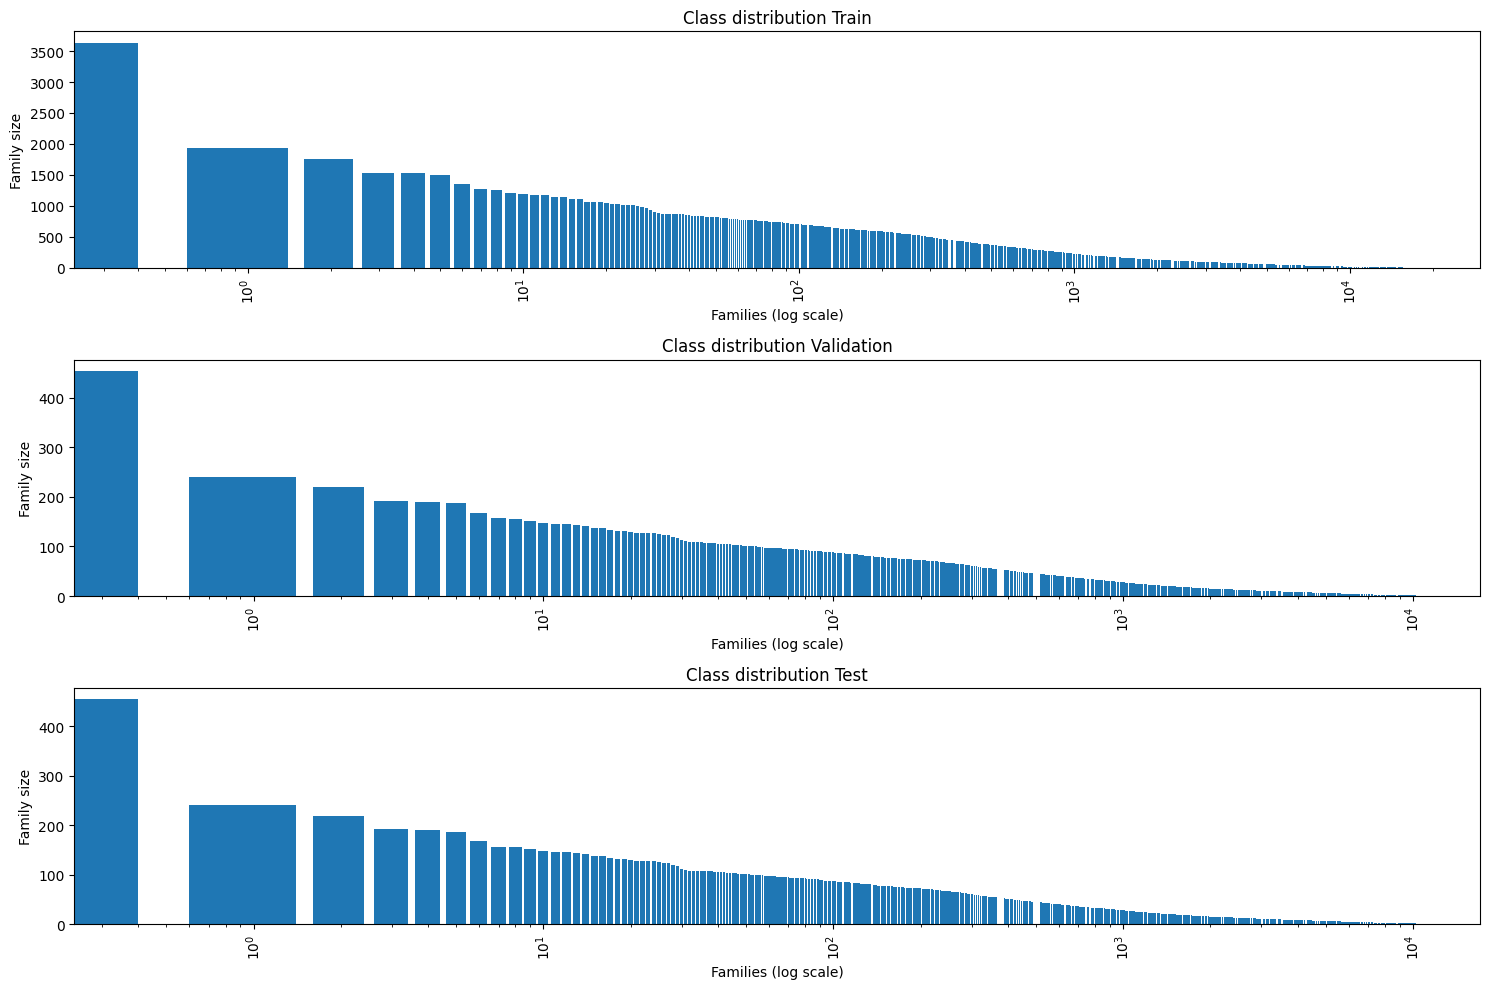

In [ ]:
classes = [train_class_representation, val_class_representation, test_class_representation]

figure, ax = plt.subplots(3, 1, figsize=(15, 10))
for i, class_rep in enumerate(classes):
    ax[i].bar(class_rep.index, class_rep.values)
    ax[i].set_xticks(np.arange(0, len(class_rep.index), step=1000))
    ax[i].set_xticklabels(class_rep.index[::1000], rotation=90)
    ax[i].set_xscale('log')
    ax[i].set_xlabel("Families (log scale)")
    ax[i].set_ylabel("Family size")
    ax[i].set_title(f"Class distribution {['Train', 'Validation', 'Test'][i]}")

plt.tight_layout()
plt.show()

In [ ]:
train_data[train_data.iloc[:,2]=="PF13649.6"].head()

,family_id,sequence_name,family_accession,aligned_sequence,sequence
154,Methyltransf_25,I0H660_ACTM4/51-146,PF13649.6,VLDVGCGT.G...V..TT...RA..AA.AA.......A...........,VLDVGCGTGVTTRAAAAAAPAGHALGVDLSSAMIDVARGLAGRAGL...
245,Methyltransf_25,N4UQ24_FUSC1/58-155,PF13649.6,VLELGCGS.G...S........P..FI.ST.......LL.ARA......,VLELGCGSGSPFISTLLARAPSVHVHANDLSDVQLDLARQNLAGYQ...
272,Methyltransf_25,D1CBP9_THET1/45-135,PF13649.6,IADVGAGT.G...R..FA...AQ..LA.RI.......G...........,IADVGAGTGRFAAQLARIGVNVVAIEPSGPMRDIGVRTTRDLSVRW...
561,Methyltransf_25,W4ZJS9_STRPU/116-210,PF13649.6,VLEVGCGS.G...R..LC...KI..LS.PR.......V...........,VLEVGCGSGRLCKILSPRVNSVTGLDISVGLIELAKRENPASNVQF...
1328,Methyltransf_25,A1SCG4_NOCSJ/64-155,PF13649.6,VLDVACGT.G...V..VA...RA..AR.DL.......V....G......,VLDVACGTGVVARAARDLVGPGGRVVGVDLNSAMLEVAQEARPDLE...


### Sequences' analysis

As for the class distribution, the number of sequences exponentially decreases with their length. Half of the sequences have a length of 119 residues, but some can reach up to 2,037 residues.

This poses a significant challenge for data embedding: padding all sequences to the maximum possible length would be computationally inefficient. Therefore, we will need to truncate some sequences, even though this may result in missing sections that are crucial for their classification.

count    1.086741e+06
mean     1.553800e+02
std      1.201232e+02
min      4.000000e+00
25%      7.600000e+01
50%      1.190000e+02
75%      1.950000e+02
max      2.037000e+03
Name: sequence, dtype: float64


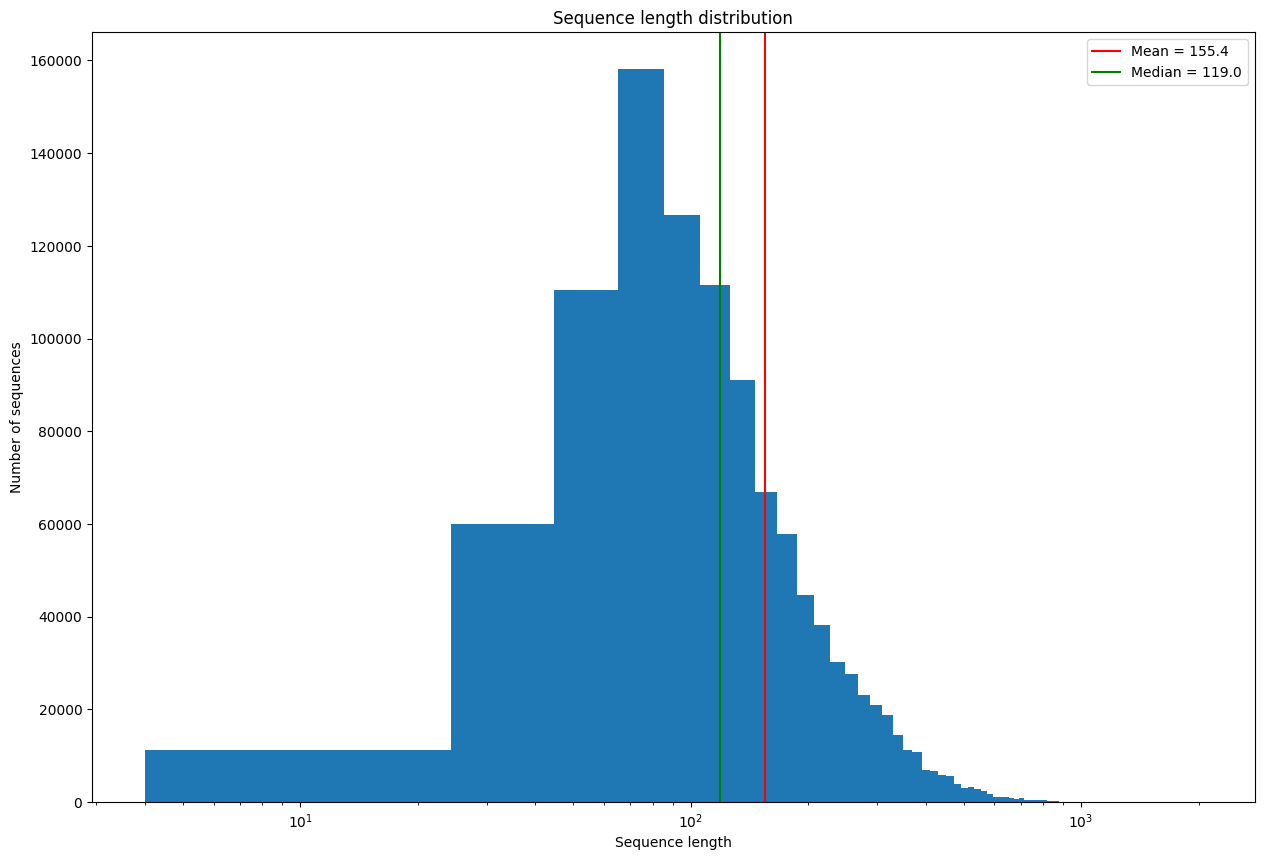

In [ ]:
sequences_len = train_data.iloc[:,4].apply(len)
train_mean = sequences_len.mean()
train_median = sequences_len.median()
print(sequences_len.describe())

fig, ax = plt.subplots(figsize=(15, 10))
ax.axvline(train_mean, color='r', linestyle='-', label=f"Mean = {train_mean:.1f}")
ax.axvline(train_median, color='g', linestyle='-', label=f"Median = {train_median:.1f}")
ax.legend()
plt.hist(sequences_len, bins=100)
plt.xscale('log')
plt.xlabel("Sequence length")
plt.ylabel("Number of sequences")
plt.title("Sequence length distribution")
plt.show()

### Explore differences between aligned sequences and sequences

Aligned sequences were obtained using profile HMMs. All sequences were padded with '.' (as determined by the profile HMM) to match the length of the longest sequence within their class.

In the following, I will not use aligned sequences, even though I could have opted for simpler machine learning models like BLASTp or HMMER.

In [ ]:
train_data.iloc[4]

,4
0,
family_id,Filamin
sequence_name,A7SQM3_NEMVE/342-439
family_accession,PF00630.19
aligned_sequence,TACPKQ.CTA....RGLG.............LK.AAPVT.QPT..R...
sequence,TACPKQCTARGLGLKAAPVTQPTRFVVILNDCHGQPLGRSEGELEV...


In [ ]:
fam = pd.DataFrame(columns=['family_accession', 'sequence_name', 'len_seq', 'len_aligned_seq'])
fam['family_accession'] = train_data[train_data.iloc[:,2]=="PF13649.6"].iloc[:,2]
fam['sequence_name'] = train_data[train_data.iloc[:,2]=="PF13649.6"].iloc[:,1]
fam['len_seq'] = train_data[train_data.iloc[:,2]=="PF13649.6"].iloc[:,4].apply(len)
fam['len_aligned_seq'] = train_data[train_data.iloc[:,2]=="PF13649.6"].iloc[:,3].apply(len)
fam.head()

,family_accession,sequence_name,len_seq,len_aligned_seq
154,PF13649.6,I0H660_ACTM4/51-146,96,242
245,PF13649.6,N4UQ24_FUSC1/58-155,98,242
272,PF13649.6,D1CBP9_THET1/45-135,91,242
561,PF13649.6,W4ZJS9_STRPU/116-210,95,242
1328,PF13649.6,A1SCG4_NOCSJ/64-155,92,242


### Amino acids frequencies in sequences

We can see here that the seven most represented residues in the sequences (>10M in the three datasets) are : L, A, V, G, E, S and I.

On the contrary, 4 residues are very less common (with less than 10 representants in the validation and test sets) : U, B, O and Z.

In [ ]:
def get_freq_df():
    dic_residues = {}
    datasets = [train_data, val_data, test_data]
    for j, dataset in enumerate(datasets):
        for i in range(len(dataset)):
            seq = train_data.iloc[i,4]
            for res in seq:
                if res in dic_residues:
                    if len(dic_residues[res]) == j:
                        while len(dic_residues[res]) < j:
                            dic_residues[res].append(0)
                        dic_residues[res].append(1)
                    else:
                        dic_residues[res][j] += 1
                else:
                    if j == 0:
                        dic_residues[res] = [1]
                    else:
                        while len(dic_residues[res]) < j:
                            dic_residues[res].append(0)
                        dic_residues[res] = [1]
    freq_df = pd.DataFrame.from_dict(dic_residues, orient='index', columns=['Train', 'Validation', 'Test'])
    freq_df = freq_df.sort_values(by='Train', ascending=False)
    return freq_df

In [ ]:
freq_df = get_freq_df()
freq_df

,Train,Validation,Test
L,17062816,1983443,1983443
A,14384873,1674073,1674073
V,11913147,1384821,1384821
G,11845579,1378861,1378861
E,10859966,1262198,1262198
S,10597822,1231120,1231120
I,10234455,1189296,1189296
R,9406165,1092855,1092855
D,9371097,1090449,1090449
K,9127832,1060251,1060251


## Models selection

The dataset analysis indicates that the multi-class classification task is particularly challenging due to the large number of labels, most of which have few representatives.

Furthermore, as shown in the paper by Bileschi et al. [1], a random split can somewhat mitigate the problem of class imbalance across the training, validation, and test datasets. However, this approach can lead to models that easily overfit due to similarities shared between the training and validation/test sets. These models also tend to be less generalizable compared to those trained on datasets split by clustering. On the other hand, a clustered split would have made training more complex and likely resulted in lower accuracy.

In the following, I worked only with non-aligned sequences.

### Sequences and labels embeddings

* **Sequences Embeddings:**

To embed the sequences, I followed the work of Bileschi et al. [1] and applied this embedding method across all models.

For residue encoding, **I mapped the 20 most common residues to indices between 0 and 19, and created an additional class to map the 4 less common residues (B, O, U, and Z) to index 20.** Since these 4 residues appear fewer than 10 times in the validation and training sets, it was computationally inefficient to allocate a separate class for each.

For computational efficiency, I determined a maximum sequence length to be handled by the models. Sequences shorter than this length were padded, while those exceeding it were truncated. I set this parameter to 200, as 75% of the sequences had lengths of less than 195. To truncate a sequence $S$ of length $L>200$, I selected $S[i:i+200]$, with $i$ randomly chosen from $[0,L−200]$.

Finally, I used a one-hot encoder with 21 classes to obtain the final embeddings.

* **Labels Embeddings:**

For label encoding, I used the *LabelEncoder* function from scikit-learn, which avoids the need to one-hot encode the labels.

### Part I : Models over a restricted dataset

#### Dataset restriction

In a first approach to the problem, I considered a restricted dataset. This allowed me to evaluate which model was most effective for the multi-class classification task on this type of data.

To achieve this, I trained my models only on sequences whose classes were represented in both the validation and test datasets.

Additionally, I selected only the sequences from all datasets that belonged to the 100 most represented classes in the training set.

This resulted in a restricted training set of approximately **92,000 sequences**, compared to the 1.086 million sequences in the full training set.



#### Model 1 : ProtCNN

The paper by Bileschi et al. [1] demonstrated that traditional machine learning and statistical models like BLASTp and HMMER are less accurate on the Pfam-seed dataset compared to deep learning models such as ProtCNN and ProtENN (where ProtENN is an ensemble method based on ProtCNN). This is why I chose to implement ProtCNN on the restricted dataset.

ProtCNN is inspired by the ResNet architecture, incorporating several residual blocks to learn robust sequence embeddings, and subsequently assigns the most probable class using a softmax function.



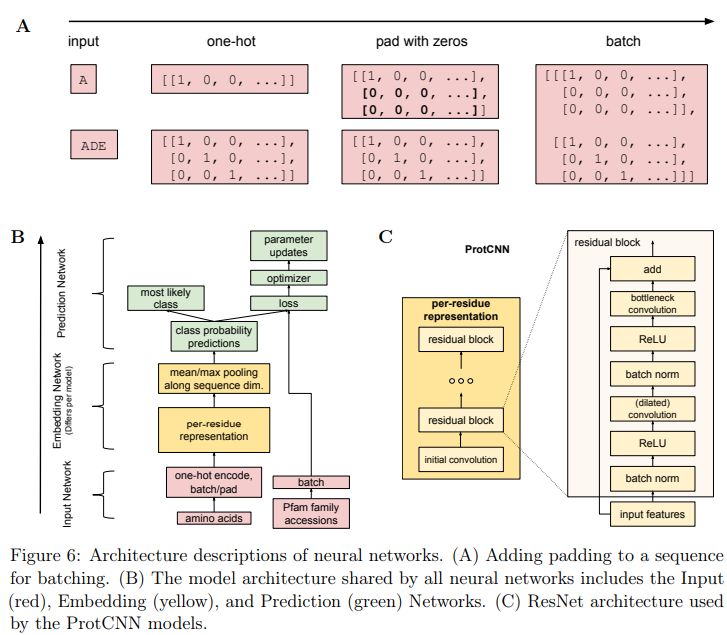

*Figure from the paper Bileschi and al. [1]*

I used an Adam optimizer and a Cross-Entropy loss to train the model,  consistently with the paper approach.

#### Model 2 : Vanilla Transformer with Positionnal Encoding

I haven't come across any papers that apply a Transformer approach to the Pfam-seed dataset, but I assumed that it could yield better results than previous models, given that Transformers are designed to handle sequential data. This approach is also favored in recent protein analysis methods, such as ESM and AlphaFold. Unlike RNNs, Transformers do not require sequential processing and can simultaneously manage different parts of a sequence.

I experimented with the vanilla Transformer Encoder layer (from Vaswani et al. [2]) to learn the embedding of a given sequence, and I prefaced this layer with a Positional Encoder, as the order of residues in the sequence is crucial.

### Part II : Training over the whole dataset with Representative Learning and a Constrastive Loss

Due to the final linear layer of ProtCNN, which would have resulted in an enormous number of weight parameters to learn $(embedding\_size \times 17,929)$, and because I could not load the entire embedded dataset $(1.087M \times 200 \times 21 \approx 4000M)$, I initially restricted the dataset.

However, similar to the task of face recognition in a crowd in computer vision, we cannot always afford to quickly remove samples and labels.

In the field of computer vision, there is a method to handle such problems called **Representation Learning based on a Contrastive Loss**. This method is well explained in the video [3] by Andrei Bursuc.

**The key idea is that instead of training a classifier with a large number of classes and few samples per class, we can train the model to compute useful features from sequences, enabling us to measure similarities and dissimilarities between sequences.**

#### Contrastive Loss

The basic idea of contrastive loss is to encourage the model to bring similar pairs of data points closer together in the learned space while pushing dissimilar pairs further apart.

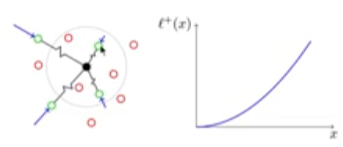

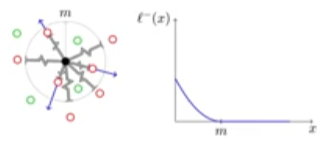

We can help the model learn the embedding of a sequence (called the anchor, $S_a$) by comparing it to a positive sample $S_p$ and a negative sample $S_n$. A positive sample is from the same class as the anchor, while a negative sample is from a different class. In this setup, the anchor can be compared with a positive example and several negative examples.

I define the contrastive loss as follows:
$$Contrastive\_Loss = ||S_a - S_p ||^2 + (\sum_{i} m - ||S_a - S_{n_i}||^2)_+$$
where $|| . - . ||^2$ denotes the euclidean distance between the embeddings of two sequences, and $m$ is a margin.

The goal is to push apart sequences that are close in the representation space but do not belong to the same class. Therefore, the closer these samples are, the greater the loss. If the anchor and a negative sample are already far from each other, it won't help the model to improve further, so this part of the loss is set to 0 if the distance exceeds $m$.

#### DataLoader, Model and Trainer adaptation

This new approach requires some adjustments to the dataloader, model, and trainer.

* **Datasets and DataLoaders**

The dataset provided to the training dataloader now needs to return, in the get_item method, a data tensor of size $(n,seq\_length,21)$ (instead of $(seq\_length,21)$) and a label tensor of size $n$ (instead of size 1), where $n$ is the number of samples used by the model to learn a good representation of the anchor, including the anchor itself. Here, $n=3$ is chosen, consisting of the anchor, a positive sample, and a negative sample. The positive and negative samples are selected randomly, respectively from the anchor's class and from other classes.

For the validation and test sets, we retain the previous PfamDataset class from the first approach.

Another challenge is the inability to load the entire embedded sequence dataset into RAM in Colab. To address this, we store the embedded labels in RAM but embed the sequences on-the-fly when they are accessed by the model in the get_item method from the dataset. This results in an extended running time.

* **Model: ProtCNN**

The model now needs to return a feature vector for each sequence, so the final linear layer has been replaced by two linear layers spaced by a ReLu layer, both having the same input and output sizes, which is the feature size (in the following set to 128).

We also need to accommodate the fact that the training data and the validation/test data do not have the same shape, which is straightforward to manage.

* **Trainer:**

The trainer must be adapted to handle the new data shapes and the fact that we can no longer compute the training set accuracy or the validation set loss in the same way as before.

To compute the accuracy on the validation set, we compare each sequence's feature vector with the representation vector of each class from the training set. The representation vector for a class is computed as the mean of the feature vectors of its representatives. We then select the class with the closest distance to the sequence's feature vector. The same approach is applied to the test dataset.

Since this is computationally intensive, I used the validation set as a test set because evaluating the model's performance on the test set would have required too much running time. In this version, each epoch takes approximately 20 minutes, and it requires an equivalent amount of time to compute the model's performance on the validation set.

## Experimentations



In [ ]:
import time
import random
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder

### Utils : Trainers and parameters count

In [ ]:
def print_model_parameters(model):
    total_params = 0
    print(f"{'Layer Name':<40} {'Param Shape':<30} {'# Params'}")
    print("="*80)

    for name, param in model.named_parameters():
        if param.requires_grad:
            param_shape = tuple(param.size())
            param_count = param.numel()
            total_params += param_count
            print(f"{name:<40} {str(param_shape):<30} {param_count}")

    print("="*80)
    print(f"Total number of parameters: {total_params}")

    return total_params

In [ ]:
class Trainer:
    def __init__(self, model, train_loader, val_loader, criterion, optimizer, device, log_dir="logs"):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device
        self.logs_train_acc = []
        self.logs_train_loss = []
        self.logs_val_acc = []
        self.logs_val_loss = []
        self.logs_train_time = []
        self.logs_val_time = []
        self.logs_train_loss = []
        self.logs_val_loss = []

    def train_epoch(self):
        self.model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in self.train_loader:
            inputs, labels = inputs.to(self.device), labels.to(self.device)

            # Forward pass
            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)

            # Backward pass and optimization
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(self.train_loader.dataset)
        epoch_accuracy = 100 * correct / total

        return epoch_loss, epoch_accuracy

    def validate(self):
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in self.val_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)

                # Forward pass
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(self.val_loader.dataset)
        epoch_accuracy = 100 * correct / total

        return epoch_loss, epoch_accuracy

    def fit(self, num_epochs):
        best_val_accuracy = 0.0

        for epoch in range(num_epochs):
            print(f"Epoch {epoch+1}/{num_epochs}")
            t = time.time()
            train_loss, train_accuracy = self.train_epoch()

            # Log training and validation metrics
            self.logs_train_loss.append(train_loss)
            self.logs_train_acc.append(train_accuracy)
            self.logs_train_time.append(time.time() - t)

            print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.2f}%")

            if epoch % 1 == 0:
                t = time.time()
                val_loss, val_accuracy = self.validate()
                self.logs_val_loss.append(val_loss)
                self.logs_val_acc.append(val_accuracy)
                self.logs_val_time.append(time.time() - t)

                print(f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_accuracy:.2f}%")

                # Save the best model
                if val_accuracy > best_val_accuracy:
                    best_val_accuracy = val_accuracy
                    torch.save(self.model.state_dict(), os.path.join("/content/drive/MyDrive/CDM/2A/InstaDeep/random_split/reprlearn_protcnn_logs", 'best_model.pth'))
                    print("Best model saved with accuracy: {:.2f}%".format(best_val_accuracy))

        print("Training complete.")

    def test(self, test_loader):
        self.model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)

                # Forward pass
                outputs = self.model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_accuracy = 100 * correct / total
        print(f"Test Accuracy: {test_accuracy:.2f}%")
        return test_accuracy

### Part I : Experimentations on a restrictive dataset

#### Dataset restriction

Remove the families that are not in the validation set

In [ ]:
train_data = train_data[train_data.iloc[:,2].isin(val_data.iloc[:,2])]

In [ ]:
train_data.iloc[:,2].describe()

,family_accession
count,1064950
unique,13071
top,PF13649.6
freq,3637


Keep the top-100 most represented families

In [ ]:
top_k = 100
top_k_families = train_data.iloc[:,2].value_counts().index[:top_k]
train_data = train_data[train_data.iloc[:,2].isin(top_k_families)]
val_data = val_data[val_data.iloc[:,2].isin(top_k_families)]
test_data = test_data[test_data.iloc[:,2].isin(top_k_families)]

In [ ]:
# Get the describe data for each set
train_desc = train_data.iloc[:, 2].describe()
val_desc = val_data.iloc[:, 2].describe()
test_desc = test_data.iloc[:, 2].describe()

# Combine them into a single DataFrame
combined_desc = pd.DataFrame({'Train': train_desc,'Validation': val_desc,'Test': test_desc})
combined_desc

,Train,Validation,Test
count,92983,11565,11565
unique,100,100,100
top,PF13649.6,PF13649.6,PF13649.6
freq,3637,454,454


#### Prepare Datasets and Dataloaders

In [ ]:
class PfamDataset(Dataset):
    def __init__(self, sequences, labels, max=256):
        self.residues = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
        self.residues_idx = {res: i+1 for i, res in enumerate(self.residues)}
        self.max = max
        seq = self.get_encoded_sequences(sequences)
        self.sequences = seq.transpose(1, 2)
        self.labels = self.get_encoded_labels(labels)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

    def map_sequences(self, sequences, max_len):
        # Pad or cut sequences to the maximum length
        num_sequences = []
        for seq in sequences:
            num_seq = np.zeros(max_len)
            if len(seq) > max_len:
                # If sequence too long, take seq[i, max_len+i] with i randomly chosen in [0, len(seq)-max_len]
                j = random.randint(0, len(seq)-max_len)
                seq = seq[j:j+max_len]
            # Map the residue to its index
            for i in range(max_len):
                res = seq[i] if i < len(seq) else 'B'
                num_seq[i] = self.residues_idx.get(res, 0)
            num_sequences.append(num_seq)
        return torch.tensor(np.array(num_sequences), dtype=torch.int64)

    def get_encoded_sequences(self, sequences):
        # Map sequences to numerical values
        seq_tensor = self.map_sequences(sequences, self.max)
        # One-hot encoding
        one_hot_tensor = torch.zeros(seq_tensor.size(0), seq_tensor.size(1), 21)
        one_hot_tensor.scatter_(2, seq_tensor.unsqueeze(-1), 1)
        return one_hot_tensor

    def get_encoded_labels(self, labels):
        # Encode labels as integers
        le = LabelEncoder()
        le.fit(labels)
        encoded_labels = le.transform(labels)
        return torch.tensor(encoded_labels, dtype=torch.int64)

In [ ]:
n_classes = 21
len_seq = 200
batch_size = 64
num_workers = 2
learning_rate = 0.001
num_epochs = 10

In [ ]:
train_dataset = PfamDataset(train_data.iloc[:, 4], train_data.iloc[:, 2], max=len_seq)
val_dataset = PfamDataset(val_data.iloc[:, 4], val_data.iloc[:, 2], max=len_seq)
test_dataset = PfamDataset(test_data.iloc[:, 4], test_data.iloc[:, 2], max=len_seq)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

#### Model 1 : ProtCNN

In [ ]:
class ResidualBlock(torch.nn.Module):

    def __init__(self, in_channels, out_channels, dil_rate):
        super(ResidualBlock, self).__init__()
        self.batchNorm1 = nn.BatchNorm1d(in_channels)
        self.relu1 = nn.ReLU()
        self.dilated_conv = nn.Conv1d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, dilation=dil_rate, padding=dil_rate)
        self.batchNorm2 = nn.BatchNorm1d(out_channels)
        self.relu2 = nn.ReLU()
        self.bottleneck_conv = nn.Conv1d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding=1)


    def forward(self, x):
        # input size : [batch_size, h_dim, len_seq]
        z = self.batchNorm1(x)          # output size : [batch_size, h_dim, len_seq]
        z = self.relu1(z)               # output size : [batch_size, h_dim, len_seq]
        z = self.dilated_conv(z)        # output size : [batch_size, h_dim, len_seq]
        z = self.batchNorm2(z)          # output size : [batch_size, h_dim, len_seq]
        z = self.relu2(z)               # output size : [batch_size, h_dim, len_seq]
        z = self.bottleneck_conv(z)     # output size : [batch_size, h_dim, len_seq]
        return z + x                    # output size : [batch_size, h_dim, len_seq]

class ProtCNN(torch.nn.Module):

    def __init__(self, input_shape, num_classes, h_dim=128, MP_kernel_size=3):
        super(ProtCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_shape[1], out_channels=h_dim, kernel_size=1, padding='same')
        self.residualBlock1 = ResidualBlock(h_dim, h_dim, dil_rate=2)
        self.residualBlock2 = ResidualBlock(h_dim, h_dim, dil_rate=3)
        self.linear = nn.Linear(h_dim, num_classes)

    def forward(self, x):
        # input size : [batch_size, 21, len_seq]
        x = self.conv1(x)             # output size : [batch_size, h_dim, len_seq]
        x = self.residualBlock1(x)    # output size : [batch_size, h_dim, len_seq]
        x = self.residualBlock2(x)    # output size : [batch_size, h_dim, len_seq]
        x = torch.max(x, dim=2)[0]    # output size : [batch_size, h_dim]
        x = self.linear(x)            # output size : [batch_size, num_classes]
        return F.softmax(x, dim=-1)   # output size : [batch_size, num_classes]


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
print('Device is : ', device)

input_shape = (len_seq, n_classes)  # (sequence_length, num_features)
num_classes = 100

model = ProtCNN(input_shape, num_classes).to(device)
print_model_parameters(model)

Device is :  cuda
Layer Name                               Param Shape                    # Params
conv1.weight                             (128, 21, 1)                   2688
conv1.bias                               (128,)                         128
residualBlock1.batchNorm1.weight         (128,)                         128
residualBlock1.batchNorm1.bias           (128,)                         128
residualBlock1.dilated_conv.weight       (128, 128, 3)                  49152
residualBlock1.dilated_conv.bias         (128,)                         128
residualBlock1.batchNorm2.weight         (128,)                         128
residualBlock1.batchNorm2.bias           (128,)                         128
residualBlock1.bottleneck_conv.weight    (128, 128, 3)                  49152
residualBlock1.bottleneck_conv.bias      (128,)                         128
residualBlock2.batchNorm1.weight         (128,)                         128
residualBlock2.batchNorm1.bias           (128,)             

213860

In [ ]:
# Les loaders train_loader, val_loader et test_loader sont définis avec DataLoader
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

trainer = Trainer(model, train_dataloader, val_dataloader, criterion, optimizer, device)

# Entraînement du modèle
trainer.fit(num_epochs=10)

# Évaluation sur le jeu de test
trainer.test(test_dataloader)

Epoch 1/10
Train Loss: 4.5646 | Train Accuracy: 5.69%
Validation Loss: 4.4631 | Validation Accuracy: 15.81%
Best model saved with accuracy: 15.81%
Epoch 2/10
Train Loss: 3.8442 | Train Accuracy: 78.35%
Validation Loss: 3.7070 | Validation Accuracy: 91.73%
Best model saved with accuracy: 91.73%
Epoch 3/10
Train Loss: 3.6900 | Train Accuracy: 93.36%
Validation Loss: 3.6862 | Validation Accuracy: 93.68%
Best model saved with accuracy: 93.68%
Epoch 4/10
Train Loss: 3.6843 | Train Accuracy: 93.85%
Validation Loss: 3.6837 | Validation Accuracy: 93.91%
Best model saved with accuracy: 93.91%
Epoch 5/10
Train Loss: 3.6829 | Train Accuracy: 93.98%
Validation Loss: 3.6859 | Validation Accuracy: 93.67%
Epoch 6/10
Train Loss: 3.6820 | Train Accuracy: 94.05%
Validation Loss: 3.6785 | Validation Accuracy: 94.41%
Best model saved with accuracy: 94.41%
Epoch 7/10
Train Loss: 3.6749 | Train Accuracy: 94.75%
Validation Loss: 3.6775 | Validation Accuracy: 94.51%
Best model saved with accuracy: 94.51%
Epoc

94.47470817120623

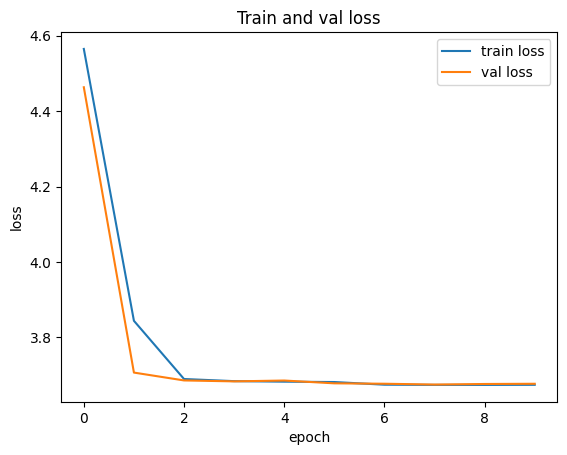

In [ ]:
#visualize train loss
plt.plot(trainer.logs_train_loss, label='train loss')
plt.plot(trainer.logs_val_loss, label='val loss')
plt.legend()
plt.title('Train and val loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

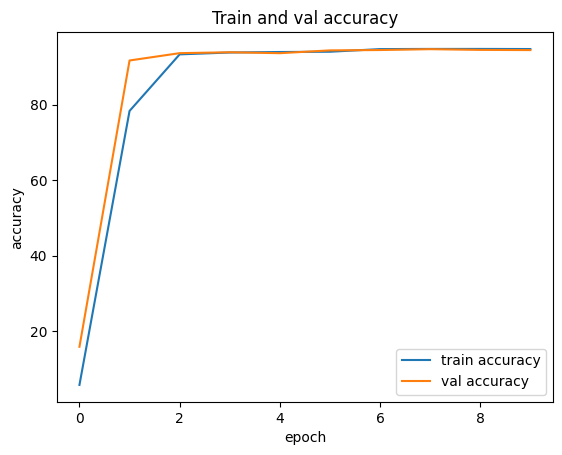

In [ ]:
#visualize train and val accuracy
plt.plot(trainer.logs_train_acc, label='train accuracy')
plt.plot(trainer.logs_val_acc, label='val accuracy')
plt.legend()
plt.title('Train and val accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

#### Model 2 : Transformer

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class TransformerModel(nn.Module):
    def __init__(self, input_dim=21, max_seq_len=200, d_model=128, nhead=8, num_encoder_layers=4, dim_feedforward=512, dropout=0.1, num_classes=10):
        super(TransformerModel, self).__init__()

        # Positional Encoding
        self.positional_encoding = PositionalEncoding(d_model, dropout, max_seq_len)

        # Linear layer to project input_dim to d_model
        self.input_projection = nn.Linear(input_dim, d_model)

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)

        # Classification head
        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, x):
        # x: [batch_size, seq_len, input_dim]
        x = x.transpose(1,2)

        # Project input to d_model
        x = self.input_projection(x)  # [batch_size, seq_len, d_model]

        # Apply positional encoding
        x = self.positional_encoding(x)

        # Transformer expects input as [seq_len, batch_size, d_model], so we transpose
        x = x.permute(1, 0, 2)  # [seq_len, batch_size, d_model]

        # Pass through Transformer Encoder
        x = self.transformer_encoder(x)  # [seq_len, batch_size, d_model]

        # We can use the output at the first position (or average pool over all positions)
        x = x[0]  # [batch_size, d_model]

        # Classification
        x = self.fc(x)  # [batch_size, num_classes]
        return x

In [ ]:
# Example of how to instantiate and use the model
input_dim = 21
max_seq_len = 200
num_classes = 100

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device : ', device)

# Instantiate the model
model = TransformerModel(input_dim=input_dim, max_seq_len=max_seq_len, num_classes=num_classes).to(device)

print_model_parameters(model)

Device :  cuda
Layer Name                               Param Shape                    # Params
input_projection.weight                  (128, 21)                      2688
input_projection.bias                    (128,)                         128
transformer_encoder.layers.0.self_attn.in_proj_weight (384, 128)                     49152
transformer_encoder.layers.0.self_attn.in_proj_bias (384,)                         384
transformer_encoder.layers.0.self_attn.out_proj.weight (128, 128)                     16384
transformer_encoder.layers.0.self_attn.out_proj.bias (128,)                         128
transformer_encoder.layers.0.linear1.weight (512, 128)                     65536
transformer_encoder.layers.0.linear1.bias (512,)                         512
transformer_encoder.layers.0.linear2.weight (128, 512)                     65536
transformer_encoder.layers.0.linear2.bias (128,)                         128
transformer_encoder.layers.0.norm1.weight (128,)                         128


808804

In [ ]:
# Les loaders train_loader, val_loader et test_loader sont définis avec DataLoader
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

trainer = Trainer(model, train_dataloader, val_dataloader, criterion, optimizer, device)

# Entraînement du modèle
trainer.fit(num_epochs=10)

# Évaluation sur le jeu de test
trainer.test(test_dataloader)

Epoch 1/10
Train Loss: 2.6044 | Train Accuracy: 22.41%
Validation Loss: 1.8945 | Validation Accuracy: 38.81%
Best model saved with accuracy: 38.81%
Epoch 2/10
Train Loss: 1.3211 | Train Accuracy: 57.49%
Validation Loss: 0.7608 | Validation Accuracy: 76.24%
Best model saved with accuracy: 76.24%
Epoch 3/10
Train Loss: 0.6493 | Train Accuracy: 79.38%
Validation Loss: 0.5231 | Validation Accuracy: 83.75%
Best model saved with accuracy: 83.75%
Epoch 4/10
Train Loss: 0.4620 | Train Accuracy: 85.36%
Validation Loss: 0.3736 | Validation Accuracy: 88.35%
Best model saved with accuracy: 88.35%
Epoch 5/10
Train Loss: 0.3820 | Train Accuracy: 87.82%
Validation Loss: 0.3540 | Validation Accuracy: 89.06%
Best model saved with accuracy: 89.06%
Epoch 6/10
Train Loss: 0.3431 | Train Accuracy: 89.05%
Validation Loss: 0.3328 | Validation Accuracy: 90.00%
Best model saved with accuracy: 90.00%
Epoch 7/10
Train Loss: 0.3185 | Train Accuracy: 89.92%
Validation Loss: 0.2648 | Validation Accuracy: 91.80%
Bes

91.50886294855167

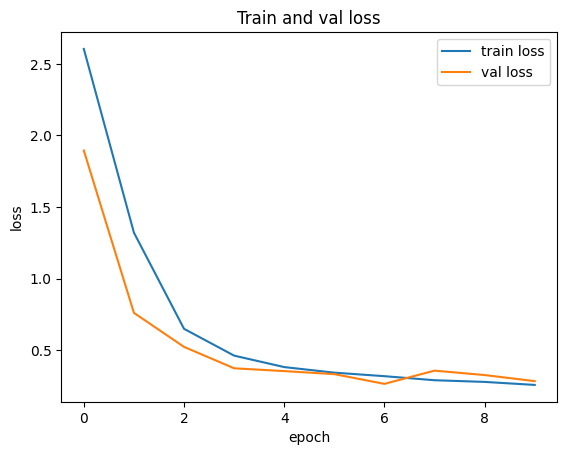

In [ ]:
#visualize train loss
plt.plot(trainer.logs_train_loss, label='train loss')
plt.plot(trainer.logs_val_loss, label='val loss')
plt.legend()
plt.title('Train and val loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

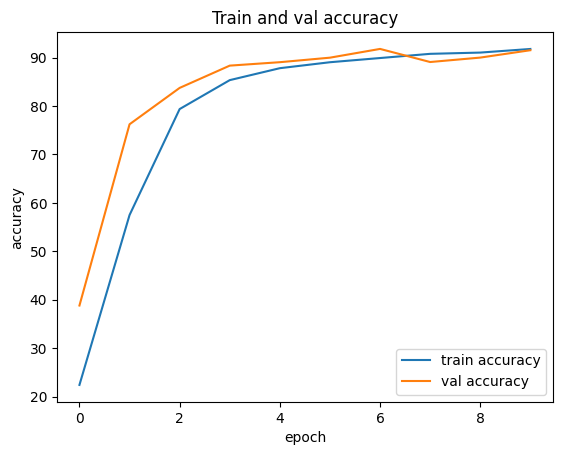

In [ ]:
#visualize train and val accuracy
plt.plot(trainer.logs_train_acc, label='train accuracy')
plt.plot(trainer.logs_val_acc, label='val accuracy')
plt.legend()
plt.title('Train and val accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

### Part II : Constrastive learning on the whole dataset

##### Trainer : Update

In [ ]:
class Trainer_ReprLearn:
    def __init__(self, model, train_loader, val_loader, criterion, optimizer, device, log_dir="logs"):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device
        self.logs_train_loss = []
        self.logs_val_acc = []
        self.logs_train_time = []
        self.logs_val_time = []
        self.class_embeddings = {}

    def train_epoch(self):
        self.model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        i = 0

        for inputs, labels in self.train_loader:
            inputs, labels = inputs.to(self.device), labels.to(self.device)

            # Forward pass
            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)

            # Backward pass and optimization
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)

            if i % 1500 == 0:
                print(f"Batch Loss {i+1}/{running_loss/(i+1)}")
            i += 1

        epoch_loss = running_loss / len(self.train_loader.dataset)

        return epoch_loss

    def validate(self):
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0

        # Compute the array of classes' feature vector
        with torch.no_grad():
            for inputs, labels in self.train_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)

                # Forward pass
                outputs = self.model(inputs)
                outputs = outputs[:,0,:] # keep only the embedding of the anchor

                # Add class representant feature vector to its class in the dictionnary
                for i, label in enumerate(labels):
                    label = label[0]
                    if label.item() not in self.class_embeddings:
                        self.class_embeddings[label.item()] = outputs[i].unsqueeze(0)
                    else:
                        self.class_embeddings[label.item()] = torch.cat((self.class_embeddings[label.item()], outputs[i].unsqueeze(0)), dim=0)

            # Compute the mean of all class representants' feature vectors per class
            for class_label, embeddings in self.class_embeddings.items():
                self.class_embeddings[class_label] = torch.mean(embeddings, dim=0)

            # Compute the matrix of class embeddings and keep the classes label corresponding to each row
            self.train_embeddings = torch.stack(list(self.class_embeddings.values())).to(self.device)
            self.class_labels = torch.tensor(list(self.class_embeddings.keys())).to(self.device)
            self.train_embeddings_norm = torch.norm(self.train_embeddings, dim=1)
            self.train_labels = torch.tensor(list(self.class_embeddings.keys())).to(self.device)

        # Compare validation sequences' feature vectors to the classes' feature vector and predict
        with torch.no_grad():
            for inputs, labels in self.val_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)

                # Forward pass
                outputs = self.model(inputs)

                # Compute similarities with the embeddings of the classes in the training set
                train_embeddings_norm_mat = self.train_embeddings_norm.repeat(outputs.size(0), 1)
                outputs_norm = torch.norm(outputs, dim=1)                                                    # shape : [batch_size,]
                outputs_norm_mat = outputs_norm.unsqueeze(1).repeat(1, self.train_embeddings_norm.size(0))
                scalar_product = torch.matmul(outputs, self.train_embeddings.transpose(0,1))
                similarities = train_embeddings_norm_mat + outputs_norm_mat - 2 * scalar_product             # shape : [batch_size, n_classes]

                # Predict the labels
                argmin_similarities = torch.argmin(similarities, dim=1)
                predicted = []
                for i in range(argmin_similarities.size(0)):
                    predicted.append(self.class_labels[argmin_similarities[i].item()])
                predicted = torch.stack(predicted)

                # Statistics
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        epoch_accuracy = 100 * correct / total

        return epoch_accuracy

    def fit(self, num_epochs):
        best_train_loss = 10.0

        for epoch in range(num_epochs):
            print(f"Epoch {epoch+1}/{num_epochs}")
            t = time.time()
            train_loss = self.train_epoch()

            # Log training and validation metrics
            self.logs_train_loss.append(train_loss)
            self.logs_train_time.append(time.time() - t)

            print(f"Train Loss: {train_loss:.4f}")

            # Print validation accuracy
            if epoch % 3 == 0:
                val_accuracy = self.validate()
                self.logs_val_acc.append(val_accuracy)

            # Save the best model
            if train_loss < best_train_loss:
                best_train_loss = train_loss
                torch.save(self.model.state_dict(), os.path.join("/content/drive/MyDrive/CDM/2A/InstaDeep/random_split/reprlearn_protcnn_logs", 'best_model.pth'))
                print("Best model saved with training loss: {:.2f}%".format(best_train_loss))


        t = time.time()
        val_accuracy = self.validate()
        self.logs_val_acc.append(val_accuracy)
        self.logs_val_time.append(time.time() - t)

        print(f"Validation Accuracy: {val_accuracy:.2f}%")

        print("Training complete.")

    def test(self, test_loader):
        self.model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in self.val_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)

                # Forward pass
                outputs = self.model(inputs)

                # Compute similarities with the embeddings of the classes in the training set
                train_embeddings_norm_mat = self.train_embeddings_norm.repeat(outputs.size(0), 1)
                outputs_norm = torch.norm(outputs, dim=1)                                                    # shape : [batch_size,]
                outputs_norm_mat = outputs_norm.unsqueeze(1).repeat(1, self.train_embeddings_norm.size(0))
                scalar_product = torch.matmul(outputs, self.train_embeddings.transpose(0,1))
                similarities = train_embeddings_norm_mat + outputs_norm_mat - 2 * scalar_product             # shape : [batch_size, n_classes]

                # Predict the labels
                argmin_similarities = torch.argmin(similarities, dim=1)
                predicted = []
                for i in range(argmin_similarities.size(0)):
                    predicted.append(self.class_labels[argmin_similarities[i].item()])
                predicted = torch.stack(predicted)
                with open("/content/drive/MyDrive/CDM/2A/InstaDeep/random_split/predictions.txt", "w") as f:
                    for i in range(len(predicted)):
                        f.write(f"{predicted[i].item()}\n")

                # Statistics
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_accuracy = 100 * correct / total
        print(f"Test Accuracy: {test_accuracy:.2f}%")
        return test_accuracy

##### Datasets and Dataloaders : Update

In [ ]:
class NUpletDataset(Dataset):
    def __init__(self, data, labels, max_len=200, n=3):
        """
        Args:
            data: List or array of data points (e.g., images).
            labels: List or array of corresponding labels.
            max_len: Maximum sequence length for any sequence in the dataset.
            n: Number of elements in each n-uplet.
        """
        self.residues = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
        self.residues_idx = {res: i+1 for i, res in enumerate(self.residues)}
        self.max_len = max_len
        self.data = data.to_numpy()
        self.labels = self.get_encoded_labels(labels)
        self.n = n

        # Create a dictionary to store indices for each class
        self.class_to_indices = {}
        for idx, label in enumerate(self.labels):
            label = label.item()
            if label not in self.class_to_indices:
                self.class_to_indices[label] = []
            self.class_to_indices[label].append(idx)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Select the anchor data point and its label
        anchor_data = self.get_encoded_sequence(self.data[idx])
        anchor_label = self.labels[idx]

        # Initialize the n-uplet with the anchor
        n_uplet_data = [anchor_data]
        n_uplet_labels = [anchor_label.item()]

        # Add one positive sample (same class)
        positive_idx = random.choice(self.class_to_indices[anchor_label.item()])
        positive_data = self.get_encoded_sequence(self.data[positive_idx])
        n_uplet_data.append(positive_data)
        n_uplet_labels.append(anchor_label.item())

        # Add the remaining (n-2) negative samples (different classes)
        while len(n_uplet_data) < self.n:
            negative_label = random.choice(list(self.class_to_indices.keys()))
            if negative_label != anchor_label.item():
                negative_idx = random.choice(self.class_to_indices[negative_label])
                negative_data = self.get_encoded_sequence(self.data[negative_idx])
                n_uplet_data.append(negative_data)
                n_uplet_labels.append(negative_label)

        # Stack or concatenate the n-uplet data (if necessary)
        n_uplet_data = torch.stack(n_uplet_data)  # Shape: (n, channels, height, width)

        return n_uplet_data, torch.tensor(n_uplet_labels)

    def map_sequence(self, seq):
        # Pad or cut sequence to the max len and encode residues
        num_seq = np.zeros(self.max_len)
        if len(seq) > self.max_len:
            # If sequence too long, take seq[i, max_len+i] with i randomly chosen in [0, len(seq)-max_len]
            j = random.randint(0, len(seq)-self.max_len)
            seq = seq[j:j+self.max_len]
        for i in range(self.max_len):
            # Map residues to its index
            res = seq[i] if i < len(seq) else 'B'
            num_seq[i] = self.residues_idx.get(res, 0)
        return torch.tensor(np.array(num_seq), dtype=torch.int64)

    def get_encoded_sequence(self, sequence):
        # Encode the sequence
        seq_tensor = self.map_sequence(sequence)
        # One hot encode sequence
        one_hot_tensor = torch.zeros(seq_tensor.size(0), 21)
        one_hot_tensor.scatter_(1, seq_tensor.unsqueeze(-1), 1)
        return one_hot_tensor

    def get_encoded_labels(self, labels):
        # Encode labels
        le = LabelEncoder()
        le.fit(labels)
        encoded_labels = le.transform(labels)
        return torch.tensor(encoded_labels, dtype=torch.int64)

In [ ]:
# Parameters for Datasets & Dataloaders
n = 3
len_seq = 200

# Create datasets
train_nuplet_dataset = NUpletDataset(train_data.iloc[:,4], train_data.iloc[:,2], max_len=len_seq, n=n)
val_dataset = PfamDataset(val_data.iloc[:, 4], val_data.iloc[:, 2], max=len_seq)
test_dataset = PfamDataset(test_data.iloc[:, 4], test_data.iloc[:, 2], max=len_seq)

# Create dataloaders
train_nuplet_dataloader = DataLoader(train_nuplet_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

##### Contrastive Loss definition

In [ ]:
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, outputs, label):
        anchor = outputs[:, 0]
        positive = outputs[:, 1]
        pos_dist = torch.sum((anchor - positive) ** 2)
        neg_dist = 0
        for i in range(2, outputs.size()[1]):
            neg_dist += torch.sum((anchor - outputs[:, i]) ** 2)
        loss = pos_dist + torch.clamp(self.margin - neg_dist, min=0.0)
        return loss.mean()

##### Model ProtCNN : Update

In [ ]:
class ProtCNN_ReprLearn(torch.nn.Module):

    def __init__(self, input_shape, n=3, h_dim=128, MP_kernel_size=3):
        super(ProtCNN_ReprLearn, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_shape, out_channels=h_dim, kernel_size=1, padding='same')
        self.residualBlock1 = ResidualBlock(h_dim, h_dim, dil_rate=2)
        self.residualBlock2 = ResidualBlock(h_dim, h_dim, dil_rate=3)
        self.linear1 = nn.Linear(h_dim, h_dim)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(h_dim, h_dim)
        self.n = n

    def forward(self, x):
        train = 0
        if len(x.size()) == 4 :
            train = 1                                 # if input size of 4 dim : [batch_size, n, len_seq, h_dim] else : [batch_size, h_dim, len_seq]
            s = x.size()
            x = x.view(s[0] * s[1], s[2], s[3])
            x = x.transpose(-2, -1)
        x = self.conv1(x)                             # output size : [batch_size, h_dim, len_seq] OR if input size of 4 dim [batch_size*n, h_dim, len_seq]
        x = self.residualBlock1(x)                    # output size : [batch_size, h_dim, len_seq] OR if input size of 4 dim [batch_size*n, h_dim, len_seq]
        x = self.residualBlock2(x)                    # output size : [batch_size, h_dim, len_seq] OR if input size of 4 dim [batch_size*n, h_dim, len_seq]
        x = torch.max(x, dim=2)[0]                    # output size : [batch_size, h_dim] OR if input size of 4 dim [batch_size*n, h_dim]
        x = self.linear1(x)                           # output size : [batch_size, h_dim] OR if input size of 4 dim [batch_size*n, h_dim]
        x = self.relu(x)
        x = self.linear2(x)                           # output size : [batch_size, h_dim] OR if input size of 4 dim [batch_size*n, h_dim]
        if train :
            s = x.size()
            x = x.view(s[0] // self.n, self.n, -1)
        return x

##### Training and Model Evaluation

In [ ]:
n_classes = 21

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device : ', device)

model = ProtCNN_ReprLearn(n_classes, n).to(device)
criterion = ContrastiveLoss(margin=100)
optimizer = optim.Adam(model.parameters(), lr=0.005)

print_model_parameters(model)

Device :  cuda
Layer Name                               Param Shape                    # Params
conv1.weight                             (128, 21, 1)                   2688
conv1.bias                               (128,)                         128
residualBlock1.batchNorm1.weight         (128,)                         128
residualBlock1.batchNorm1.bias           (128,)                         128
residualBlock1.dilated_conv.weight       (128, 128, 3)                  49152
residualBlock1.dilated_conv.bias         (128,)                         128
residualBlock1.batchNorm2.weight         (128,)                         128
residualBlock1.batchNorm2.bias           (128,)                         128
residualBlock1.bottleneck_conv.weight    (128, 128, 3)                  49152
residualBlock1.bottleneck_conv.bias      (128,)                         128
residualBlock2.batchNorm1.weight         (128,)                         128
residualBlock2.batchNorm1.bias           (128,)                

233984

In [ ]:
trainer = Trainer_ReprLearn(model, train_nuplet_dataloader, val_dataloader, criterion, optimizer, device)

# Entraînement du modèle
trainer.fit(num_epochs=10)

# Évaluation sur le jeu de test
trainer.test(test_dataloader)

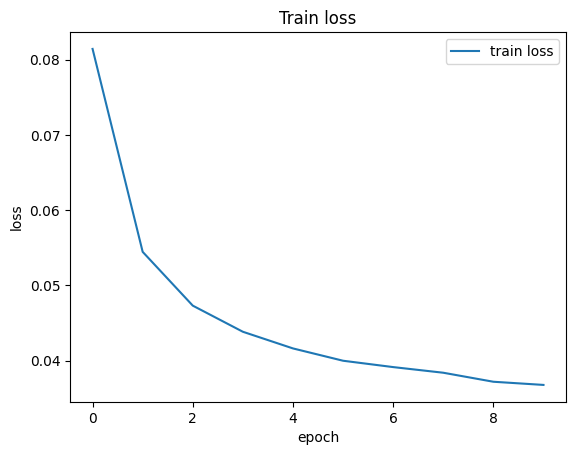

In [ ]:
#visualize train loss during the training with :
# margin = 1 (contrastive loss)
# learning rate = 0.001
# num_epoch = 10
plt.plot(trainer.logs_train_loss, label='train loss')
plt.legend()
plt.title('Train loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

## Results comparison & Conclusion

* **Part I:**

The first two models yielded similar results on the restricted dataset: ProtCNN achieved an accuracy of 94.47% on the test dataset, while the Transformer model reached an accuracy of 91.51%. After tweaking the Transformer hyperparameters, the best accuracy I achieved was with 4 heads and 4 encoder layers. Lowering the number of heads and encoder layers resulted in a similar learning curve but with the model reaching a lower plateau. Conversely, increasing the number of encoder layers or the learning rate caused the model to get stuck in a local minimum, with an accuracy of just 3.84%.

The Transformer model has four times more trainable parameters than ProtCNN (804,808 versus 213,860), resulting in significantly longer overall running times. On the restricted dataset, there was no substantial advantage to using the Transformer over the CNN model.

* **Part II:**

As for the ProtCNN model enhanced with representation learning and trained on the full dataset, it did not produce the expected results. While the loss did decrease, the final accuracy was nearly zero. I tried with several values (1, 20 and 100) for the margin, hyperparameter within the contrastive loss, and with several learning rates as well (0.01, 0.005 and 0.001) but the model remained stuck in a local minimum, predicting always the same class for each validation and test sequence.

The configuration is challenging to evaluate, as each epoch takes about 20 minutes to complete, and initiating inference requires generating the class embedding matrix (from the training set), which takes an additional 15 minutes. The overall running time is further extended by the need to embed sequences on-the-fly as they are called by the model.

Better results might be achievable by further tweaking hyperparameters, but I did not have sufficient time to experiment with them. I also did not attempt this with the Transformer model, as it already required significantly more time than ProtCNN.

* **Future work perspectives:**

It could be interesting to further investigate the representation learning approach by experimenting with different methods for computing distances between embeddings. For instance, as presented by Bursuc in the video [3], exploring the histogram loss method as an alternative might yield better results.

Additionally, we could also try to evaluate the first version of ProtCNN over the full dataset. This would require tweaking the dataloader, as was done for the representation learning method, to handle the larger dataset efficiently. Such an approach could provide valuable insights into how well ProtCNN scales and performs on a more comprehensive set of sequences.

## *Bibliography*

[1] Using Deep Learning to Annotate the Protein Universe. *Maxwell L. Bileschi, David Belanger, Drew Bryant, Theo Sanderson, Brandon Carter, D. Sculley, Mark A. DePristo, Lucy J. Colwell*, 2019,
bioRxiv 626507; doi: https://doi.org/10.1101/626507

[2] Attention is all you need. *Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin*, 2017, https://arxiv.org/abs/1706.03762

[3] Basics of Deep Learning : Siamese Representation Learning, by *Andrei Bursuc*, Dataflowr channel : https://www.youtube.com/watch?v=6x4IPITZ4dw